# 2.3 Titanic: Machine Learning from Disaster

На основании знаменитого датасета о пассажирах титаника, хотим научится предсказывать выжил пассажир титаника или нет. Для этой задачи будем использовать модель дерева решений. 

Сначала импортируем все необходимые библиотеки:

In [138]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
% matplotlib inline

А также импортируем пакеты для последующей визуализации дерева решений:

In [2]:
from IPython.display import SVG
from IPython.display import display
from graphviz import Source

In [26]:
from IPython.display import HTML
style = '<style>svg{width:50% !important;height:50 !important;}</style>'
HTML(style)

Данные скачиваем с сайта [kaggle](https://www.kaggle.com/c/titanic/data#_=_). 

Для этого присоединимся к соревнованию, воспользовавшись [kaggle-API](https://github.com/Kaggle/kaggle-api) командой, 
```
kaggle competitions download titanic
```
скачаем необходимые датасеты.

In [4]:
titanic_data = pd.read_csv('data/kaggle/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

Для начала стоит взглянуть на данные и провести предварительный анализ. Во-первых, можно посмотреть как много пропусков в датафрейме. 

In [5]:
titanic_data.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Однако, смотреть на абсолюнтные значения не очень удобно, поэтому взглянем на долю пропусков по каждому столбцу в процентах.

In [6]:
100 * titanic_data.isnull().sum() / titanic_data.shape[0]

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Видим, что очень много пропусков в столбце `Cabin`, поэтому просто исключим эту переменную из анализа. А так же, для упрощения задачи, отбросим некоторые другие признаки, а именно: `PassengerId`, `Ticket` и `Name`.

In [7]:
X = titanic_data.drop(["PassengerId", "Ticket", "Name", "Cabin", "Survived"], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
y = titanic_data.Survived
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Что ж, теперь можем обучить первую модель - дерево решений. Но для начала вспомним и учтем, что дерево предоставляет нам библиотека `sklearn`:

```Python
from sklearn import tree
```
А это значит, что на вход должны подаваться только числовые данные и ни в коем случае строки. Произведем так называемый **label encoding**, т.е. закодируем значения номинативных (качественных) переменных числами. Есть еще один вид кодирования - **one-hot encoding**, когда для каждого уровня номинативной переменной создается своя dummy переменная. Этим вариантом мы и воспользуемся, вызвав pandas-метод `get_dummies`. 


In [9]:
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Видим, что на самом деле у нас есть некоторая избыточность. Например, для предиктора `Sex` создалось 2 dummy переменных, хотя достаточно было одной. Мы можем удалить одну из dummy переменных, но т.к. будем использовать модель дерева решений, то для этой модели без разницы будет ли подано на вход две dummy переменных или одна (будь у нас другая модель, это, вообще говоря, было бы неверно. Например, модель линейной регрессии).

Но это еще не все. Перед обучением модели нужно заполнить все пропущенные значения, т.к. дерево не сможет обучиться иначе. 

Заполним пропущенные значения возраста медианным значением.

In [10]:
X = X.fillna({'Age': X.Age.median()})
X.isnull().sum()

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [11]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Итак, дерево обучилось! Осталось его визаулизировать и понять как именно оно принимает решение.

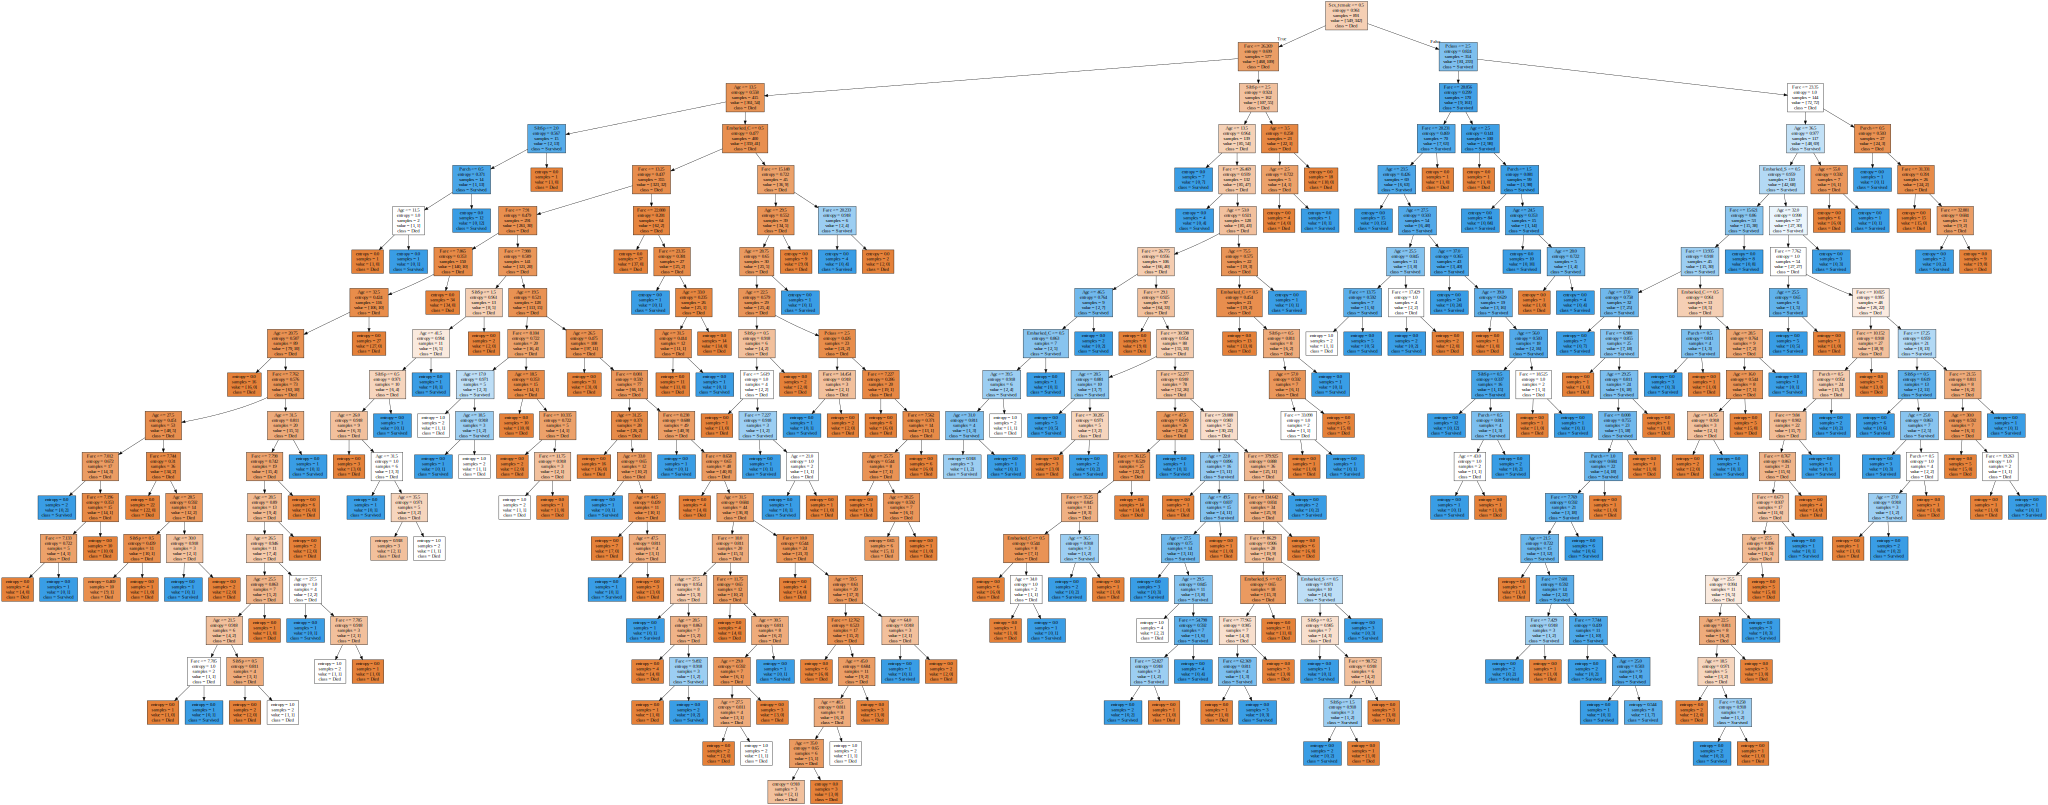

In [12]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X), class_names=['Died', 'Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

Структура дерева получилось очень сложной. Отсюда можно сделать вывод, что мы переобучили модель. Как отрегулировать модель, чтобы она была более адекватной? Во-первых, можно ограничивать высоту дерева. Во-вторых, можно разбить данные на тестовое и тренировочное множества и обучать дерево на них.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Для начала все-таки убедимся, что первая подгонка модели была переобучена. Для этого посчитаем точность классификации на тренировочном и тестовом множествах.

Исходная точность была такова:

In [15]:
clf.score(X, y)

0.9797979797979798

In [16]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
print("Accuracy on train:", clf.score(X_train, y_train), 
      "\nAccuracy on test", clf.score(X_test, y_test))

Accuracy on train: 0.9798657718120806 
Accuracy on test 0.7796610169491526


Точность прогноза на тестовом множестве значительно упала. Следовательно, высока вероятность что проблема переобучения возникла при подгонке модели.

Попробуем ограничить глубину дерева, т.к. ясно, что по самому способу построения дерево принимало наиболее "обобщающие" решения на самых первых разветвлениях.

In [18]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [19]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
print("Accuracy on train:", clf.score(X_train, y_train), 
      "\nAccuracy on test", clf.score(X_test, y_test))

Accuracy on train: 0.8406040268456376 
Accuracy on test 0.8067796610169492


Видим, что точность классификации на тестовом множестве улучшилась при меньшей глубине дерева. Попробуем еще уменьшить `max_depth` до 3.

In [21]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [22]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
print("Accuracy on train:", clf.score(X_train, y_train), 
      "\nAccuracy on test", clf.score(X_test, y_test))

Accuracy on train: 0.8238255033557047 
Accuracy on test 0.8203389830508474


Теперь точность на тестовом множестве еще больше увеличилась. 

Визуализируем возможный пример дерева с параметром максимальной глубины равным 3. Легко можно заметить, что особенно важными переменными для анализа является пол и возраст. Кстати, при помощи дерева решений можно вычленить фичи, максимально важные для решения конкретной задачи классификации, но об этом поговорим позже.

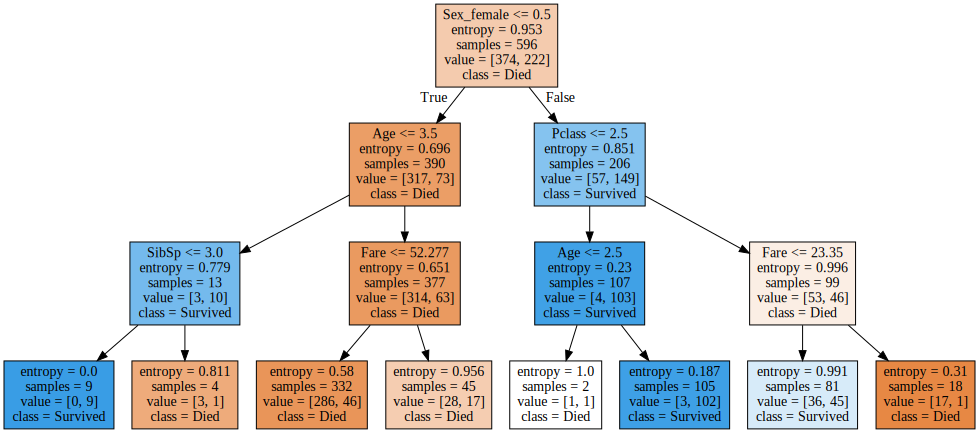

In [24]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X), class_names=['Died', 'Survived'],
                                   filled = True))
display(SVG(graph.pipe(format='svg')))

Тут же обратите внимание на еще один важный момент, если бы к нам поступил новый пассажир, и мы бы захотели, предсказать для него не только значение класса но и вероятность, того что он выживет на Титанике, это было бы несложно сделать при помощи нашего дерева. Обратите внимание, цвет финальных прямоугольничков различается, соотношение выживших/погибших пассажиров различается в финальных исходах - прямоугольничках. 

Например, если бы к нам пришло новое наблюдение Sex_male <=0.05, Pclass <= 2.5, Age > 2.5,  то предсказанная вероятность выжить была бы равна 102 / (102 + 3), то есть 97%. 

Но давайте сразу поймем, что с нашим деревом не так? Обратите внимание, что данное дерево все равно выглядит переобученным, например, есть разделение, которое приводит к тому, что под условие Age <= 2.5 проходит всего два наблюдения с разными классами, запомним эту проблему деревьев и вернемся к ней позже.

## Подбор оптимальной глубины дерева 

Для подбора оптимальной глубины дерева воспользуемся методом кросс-валидации. В `sklearn` есть встроенные функции для этого, но мы попробуем провести анализ вручную.

In [28]:
max_depth_values = range(1, 100)

In [60]:
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)    
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [61]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


Для визуализации зависимости качества предсказания на тестовом и тренировочном множествах нам лучше немного переформатировать наш датафрейм. Для этого воспользуемся функцией [`melt`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.melt.html):

In [62]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'], 
                                    var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


Теперь можем вывести график зависимостей `test_score` и `train_score` от глубины дерева. Как и ожидалось оптимальная глубина дерева находится в промежутке от 3 до 5.

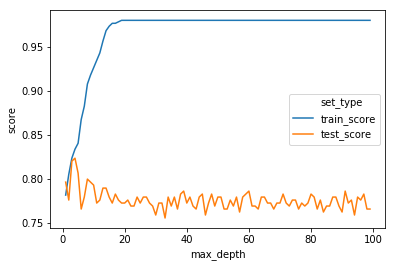

In [63]:
sns.lineplot(x='max_depth', y='score',  hue='set_type', data=scores_data_long)

In [45]:
scores_data.sort_values('test_score', ascending=False).head()

,max_depth,train_score,test_score
0,4,0.833893,0.823729
0,3,0.823826,0.820339
0,5,0.840604,0.810169
0,8,0.909396,0.800000
0,1,0.781879,0.796610


## Кросс-валидация

Предложенный алгоритм оценки моделей деревьев разной глубины хорош, но имеет существенный недостаток. Мы проверяем модель всегда лишь на одном тестовом множестве и не исключено, что мы в итоге просто выбираем то дерево, которое показало наилучшие результаты именно на нашем одном тесте. Для того, чтобы избежать такого рода ошибки, мы воспользуемся методом [кросс-валидации](https://scikit-learn.org/stable/modules/cross_validation.html).

In [46]:
from sklearn.model_selection import cross_val_score

In [47]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

Воспользуемся функцией `cross_val_score` и получим `cv=5` оценок точности классификатора:

In [49]:
cross_val_score(clf, X_train,  y_train, cv=5)

array([0.76666667, 0.80833333, 0.78991597, 0.74789916, 0.80508475])

Теперь добавим на график зависимостей точности предскзазания на тестовой и тренировочной выборке случай кросс-валидации:

In [79]:
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train,  y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    scores_data = scores_data.append(temp_score_data)

In [80]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781857
0,2,0.805369,0.776271,0.768553
0,3,0.823826,0.820339,0.788678
0,4,0.833893,0.823729,0.783580
0,5,0.840604,0.810169,0.803664


Снова воспользуемся функцией `melt`:

In [81]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'], 
                                    var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


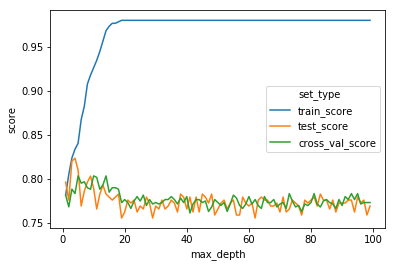

In [82]:
sns.lineplot(x='max_depth', y='score',  hue='set_type', data=scores_data_long)

Итак, видим по графикам, что оптимальная глубина по методу кросс-валидации отличается от оптимальной глубины, которые мы находили ранее.

Построим это оптимальное дерево по версии кросс-валидации:

In [83]:
scores_data_long.query("set_type == 'cross_val_score' ").sort_values('score', ascending=False).head()

,max_depth,set_type,score
202,5,cross_val_score,0.803664
207,10,cross_val_score,0.803664
211,14,cross_val_score,0.803636
208,11,cross_val_score,0.801955
204,7,cross_val_score,0.796998


Видим, что наилучшая точность получилась у дерева глубины 5. Проверим точность наилучшей модели на тестовом множестве.

In [85]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [86]:
best_clf.score(X_test, y_test)

0.8067796610169492

## Потренируемся на ирисах


In [87]:
train_iris = pd.read_csv('data/iris/train_iris.csv')
test_iris = pd.read_csv('data/iris/test_iris.csv')

In [92]:
train_iris.head()

,Unnamed: 0,sepal length,sepal width,petal length,petal width,species
0,130,7.4,2.8,6.1,1.9,2
1,7,5.0,3.4,1.5,0.2,0
2,11,4.8,3.4,1.6,0.2,0
3,142,5.8,2.7,5.1,1.9,2
4,109,7.2,3.6,6.1,2.5,2


In [93]:
test_iris.head()

,Unnamed: 0,sepal length,sepal width,petal length,petal width,species
0,114,5.8,2.8,5.1,2.4,2
1,70,5.9,3.2,4.8,1.8,1
2,138,6.0,3.0,4.8,1.8,2
3,59,5.2,2.7,3.9,1.4,1
4,44,5.1,3.8,1.9,0.4,0


In [102]:
train_iris.columns

Index(['Unnamed: 0', 'sepal length', 'sepal width', 'petal length',
       'petal width', 'species'],
      dtype='object')

In [108]:
X_train, y_train = train_iris.drop(columns=['Unnamed: 0', 'species']), train_iris.species

In [122]:
X_test, y_test = test_iris.drop(columns=['Unnamed: 0', 'species']), test_iris.species
X_test.shape

(50, 4)

In [139]:
max_depth_values = range(1, 100)
np.random.seed(0)
scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)    
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score]})
    scores_data = scores_data.append(temp_score_data)

In [140]:
scores_data.head()

,max_depth,train_score,test_score
0,1,0.70,0.60
0,2,0.97,0.94
0,3,0.99,0.94
0,4,1.00,0.92
0,5,1.00,0.92


Визуализируем результат

In [141]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score'], 
                                    var_name='set_type', value_name='score')
scores_data_long.head()

,max_depth,set_type,score
0,1,train_score,0.70
1,2,train_score,0.97
2,3,train_score,0.99
3,4,train_score,1.00
4,5,train_score,1.00


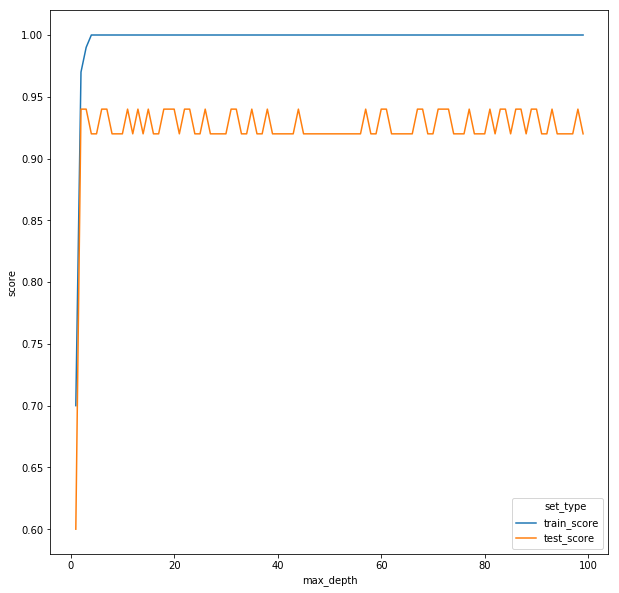

In [142]:
plt.figure(figsize=(10,10))
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)